### Problem statement

<h5> Description</h5>

<p>
Given a set of dogs images, Flip the images into 0,90,180 and 270 degress and predict the angle of rotation in the test dataset.</p>

<h5>Source</h5>
<p>
https://www.kaggle.com/tongpython/cat-and-dog</p>

<h5>Data information</h5>
<p>
Dataset consists of 4000 images for training and 1012 images for testing</p>
    
<h5> Folder structure </h5>

![image](https://user-images.githubusercontent.com/35063929/65372519-1149e400-dc8f-11e9-8d08-09b4540a4ed4.png)
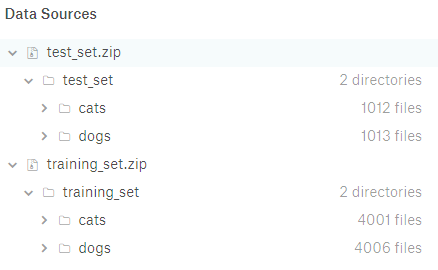

Importing the needed libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input, Activation, GlobalAveragePooling2D, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.utils import np_utils

Using TensorFlow backend.


Lets see a sample of how data looks

the number of images in our train set is 4000
C:\Users\karth\Desktop\cat-and-dog./training_set/training_set/dogs/dog.1.jpg


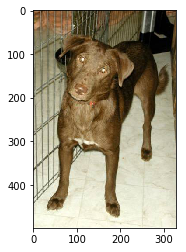

In [2]:
path = os.getcwd()
path = path + './training_set/training_set/dogs/'
data_path = os.listdir(path)
print('the number of images in our train set is',len(data_path))
for i in range(0, len(data_path)):
    print(path + data_path[i])
    img = Image.open(path + data_path[i])
    plt.imshow(img)
    break

###  Image preprocessing

Inorder to train our data on some particular networks, We need each of our images to be of same size inorder to create a size consistent array of images. Hence we will remove images which are below (100X100). There is also an option of padding them but since the number of such pictures are less than 5. We will remove them

In [23]:
to_remove = []
for index, img in enumerate(data_path):
    
    img = Image.open(path+data_path[index])
    img_array = np.asarray(img)
    shape0=(list(img_array.shape)[0])
    shape1=(list(img_array.shape)[1])
    if (shape0 & shape1) | (shape0 | shape1) < 100:    
        print(index, ' image has reduced dimensions')
        to_remove.append(index)
    else:
        continue

362  image has reduced dimensions
1322  image has reduced dimensions
1838  image has reduced dimensions
2185  image has reduced dimensions
2308  image has reduced dimensions


In [25]:
for i in to_remove:
    os.remove(path+data_path[i])
print('remove completed!')

remove completed!


### Helper functions

####  Data prep

In [3]:
def image_ops(img):
    
    "This function performs resizing, making an edge detection mask out the image and stack them to create a 3 channels"
    
    img_array = np.array(img)
    img = cv2.resize(img_array, (100, 100))
    edges=cv2.Canny(img,400,200)
    stacked_img = np.stack((edges,)*3, axis=-1)
    return stacked_img

In [4]:
def create_data(path):
    
    "This function creates an image array of all our input images given their path. This divides the total number of images\
    into 4 with each of them titled to angles 0,90,180,270 along with their respective lables and returns an image_array\
    consisting of all images"
    
    path = path
    data_path = os.listdir(path)
    test_img_list = []
    test_labels_list = []

    img_rows = 100
    img_cols = 100

    angle0 = 0
    angle90 = 90
    angle180 = 180
    angle270 = 270

    total_length = int(len(data_path))
    first_cut = int(np.floor(total_length/4))
    second_cut = int(2*first_cut)
    third_cut = int(3*first_cut)

    
    for index in range (0, total_length):

        if 0 <= index < first_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle0)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(0)


        elif first_cut<= index < second_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle90)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(90)

        elif second_cut<= index <third_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle180)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(180)

        else:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle270)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(270)

            
    test_img_array = np.array(test_img_list)
    test_img_array = test_img_array.astype('float32')
    test_img_array/=255
    
    test_labels_array = np.array(test_labels_list)
    test_labels = np.array(pd.get_dummies(test_labels_array))
    print("Sucessfully loaded!")

    return test_img_array, test_labels

In [5]:
x_train,y_train = create_data(path=os.path.join(os.getcwd(), './training_set/training_set/dogs/'))

Sucessfully loaded!


In [6]:
x_test,y_test = create_data(path=os.path.join(os.getcwd(), './test_set/test_set/dogs/'))

Sucessfully loaded!


In [7]:
# prints the dimensions of our input and test data shapes

print(x_train.shape, 'is the train shape')
print(y_train.shape, ' is the train labels shape')
print(x_test.shape, ' is the test shape')
print(y_test.shape, ' is the test labels shape')

(4000, 100, 100, 3) is the train shape
(4000, 4)  is the train labels shape
(1012, 100, 100, 3)  is the test shape
(1012, 4)  is the test labels shape


We will shuffle our dataset for the network to not have any bias while validation

In [8]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

### Label Plots

In [131]:
y_train_labels = (np.argmax(y_train, axis=1))
y_test_labels = (np.argmax(y_test, axis=1))

In [132]:
y_train_labels = pd.DataFrame({"labels":y_train_labels})
y_test_labels = pd.DataFrame({"labels":y_test_labels})

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

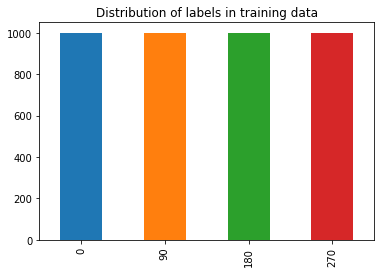

In [133]:
ax1 = y_train_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in training data")
ax1.set_xticklabels([0,90,180,270])

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

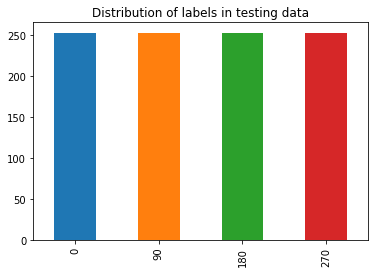

In [134]:
ax1 = y_test_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in testing data")
ax1.set_xticklabels([0,90,180,270])

Cross validation split

In [9]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

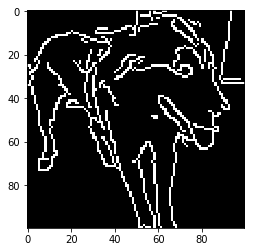

In [10]:
# so finally our training images just looks like this!

plt.imshow(x_train[10])

### Modelling

Given the data, We will try multiple models and compare their performances with each other.

<p> 1) Inception v3 with imagenet weights </p>
<p> 2) VGG16 with imagenet weights </p>
<p> 3) Custom CNN classifier </p>

are the three models we will try!

### Inception Model

In [11]:
# defining the inputs to the models

input_shape = Input(shape=(100,100,3))
inception_model = InceptionV3(include_top = True, weights = 'imagenet', input_tensor = input_shape)

In [12]:
# defining the number of classes and adding our custom 4 neuron dense layers with softmax classifier as we have 4 unique labels

num_classes = 4
last_layer = inception_model.get_layer('predictions').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
inception_final = Model(input_shape, out)
inception_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
# defining our optimizers, compile the model and making the last n layers untrainable thus making us of the weights trained
# on imagenet dataset

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

inception_final.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

for layers in inception_final.layers[:-1]:
    layers.trainable = False

In [14]:
# defining our early stopping criteria to avoid overfit

config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.1, 
                       patience=5, 
                       verbose=0, 
                       mode='auto')

In [15]:
hist = inception_final.fit(x_train,y_train, batch_size=24, epochs=50, verbose=1, validation_data=[x_cv, y_cv], callbacks=[config])

C:\Users\karth\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 104s 37ms/step - loss: 1.3652 - acc: 0.3211 - val_loss: 1.3923 - val_acc: 0.2533
Epoch 2/50
2800/2800 [==============================] - 83s 30ms/step - loss: 1.3357 - acc: 0.3464 - val_loss: 1.3999 - val_acc: 0.2533
Epoch 3/50
2800/2800 [==============================] - 84s 30ms/step - loss: 1.2751 - acc: 0.3861 - val_loss: 1.4133 - val_acc: 0.2533
Epoch 4/50
2800/2800 [==============================] - 84s 30ms/step - loss: 1.2676 - acc: 0.3868 - val_loss: 1.4254 - val_acc: 0.2533
Epoch 5/50
2800/2800 [==============================] - 83s 30ms/step - loss: 1.2762 - acc: 0.3596 - val_loss: 1.4257 - val_acc: 0.2533
Epoch 6/50
2800/2800 [==============================] - 84s 30ms/step - loss: 1.2424 - acc: 0.3786 - val_loss: 1.4378 - val_acc: 0.2533


### Accuracy and loss plots

Text(0.5,0,'epoch')

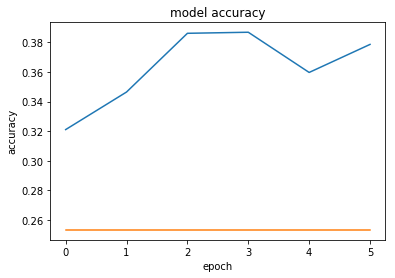

In [16]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

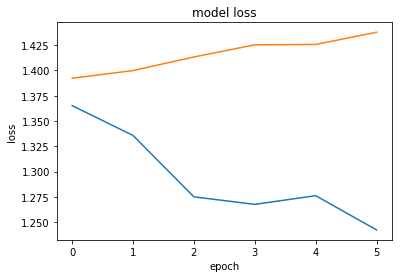

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

### Test our model

The same steps are performed with vgg net

In [77]:
(loss, accuracy) = inception_final.evaluate(x_test, y_test, batch_size=24)

1012/1012 [==============================] - 8s 8ms/step


In [78]:
print('Loss in the test set for inception v3 is', loss)
print('Accuracy in the test set for inception v3 is', accuracy)

Loss in the test set for inception v3 is 1.4415042362665471
Accuracy in the test set for inception v3 is 0.250000000471183


### vgg model

In [60]:
input_shape = Input(shape=(100,100,3))
vgg_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = input_shape)

In [61]:
#Here we will add couple of dense layers unlike in inception v3 where we added only one 4 neuron dense on top of 1000 neuron output

num_classes = 4
last_layer = vgg_model.get_layer('block5_pool').output
out1 = Flatten()(last_layer)
out2 = Dense(128, activation='softmax', name='out2')(out1)
out3 = Dense(num_classes, activation='softmax', name='output')(out2)
vgg_model = Model(input_shape, out3)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [62]:
vgg_model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

for layers in vgg_model.layers[:-1]:
    layers.trainable = False

In [63]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.1, 
                       patience=4, 
                       verbose=0, 
                       mode='min')

In [64]:
hist = vgg_model.fit(x_train,y_train, batch_size=24, epochs=50, verbose=1, validation_data=[x_cv, y_cv], callbacks=[config])

C:\Users\karth\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 170s 61ms/step - loss: 1.3870 - acc: 0.2400 - val_loss: 1.3864 - val_acc: 0.2333
Epoch 2/50
2800/2800 [==============================] - 155s 55ms/step - loss: 1.3865 - acc: 0.2571 - val_loss: 1.3867 - val_acc: 0.2333
Epoch 3/50
2800/2800 [==============================] - 155s 55ms/step - loss: 1.3864 - acc: 0.2571 - val_loss: 1.3869 - val_acc: 0.2333
Epoch 4/50
2800/2800 [==============================] - 155s 55ms/step - loss: 1.3864 - acc: 0.2571 - val_loss: 1.3870 - val_acc: 0.2333
Epoch 5/50
2800/2800 [==============================] - 155s 55ms/step - loss: 1.3864 - acc: 0.2571 - val_loss: 1.3869 - val_acc: 0.2333


### Accuracy and loss plots

Text(0.5,0,'epoch')

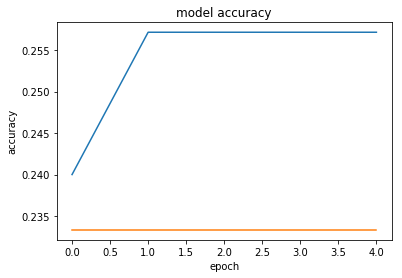

In [65]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

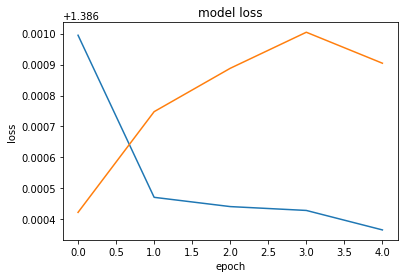

In [66]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [76]:
(loss, accuracy) = vgg_model.evaluate(x_test, y_test, batch_size=24)
print('The loss for the test dataset is ', loss)
print('The accuracy for the test dataset is ', accuracy)

1012/1012 [==============================] - 17s 17ms/step
The loss for the test dataset is  1.3863849621045259
The accuracy for the test dataset is  0.25


### Custom model

In [49]:
# Defining our sequential CNN with conv, activation and pooling layers. We initialize weights with he_normal initializer.
# We have also added drop outs in the dense neuron region to fight overfitting

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (100, 100,3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Conv2D(64, (3, 3),kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3, 3)))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(activation = 'softmax', units=4))

In [50]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics = ['accuracy']) #changed from adam to sgd

In [51]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.1, 
                       patience=4, 
                       verbose=0, 
                       mode='min')

In [54]:
hist = model.fit(x_train, y_train, batch_size=24, epochs=100, verbose=1, validation_data=(x_cv, y_cv), callbacks=[config]) # batch size 24 to 12 to 48

Train on 2800 samples, validate on 1200 samples
Epoch 1/100
2800/2800 [==============================] - 10s 3ms/step - loss: 1.4295 - acc: 0.2625 - val_loss: 1.3848 - val_acc: 0.2642
Epoch 2/100
2800/2800 [==============================] - 8s 3ms/step - loss: 1.3433 - acc: 0.3143 - val_loss: 1.2400 - val_acc: 0.3558
Epoch 3/100
2800/2800 [==============================] - 8s 3ms/step - loss: 1.2191 - acc: 0.3864 - val_loss: 1.1104 - val_acc: 0.4667
Epoch 4/100
2800/2800 [==============================] - 8s 3ms/step - loss: 1.1229 - acc: 0.4379 - val_loss: 1.0539 - val_acc: 0.4842
Epoch 5/100
2800/2800 [==============================] - 8s 3ms/step - loss: 1.0592 - acc: 0.4818 - val_loss: 1.0686 - val_acc: 0.5058
Epoch 6/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.9964 - acc: 0.5157 - val_loss: 1.0447 - val_acc: 0.4892
Epoch 7/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.9400 - acc: 0.5632 - val_loss: 1.0650 - val_acc: 0.4717


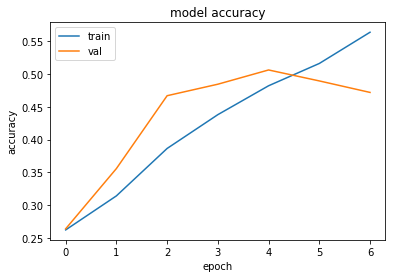

In [55]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

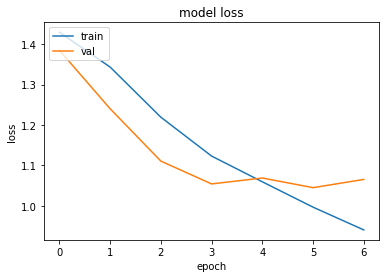

In [56]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### testing set

In [74]:
(loss, accuracy) = model.evaluate(x_test, y_test, batch_size=24, verbose=1)

1012/1012 [==============================] - 1s 1ms/step


In [75]:
print(loss, 'is the loss in test dataset')
print(accuracy*100, 'is the accuracy in test dataset')

1.0586780269626572 is the loss in test dataset
48.41897238502389 is the accuracy in test dataset


<h3> Inference </h3>

<p> We ran three models and the custom CNN seems to outperform all the other models. I assume this is because the Inceptionv3 and the vgg are pretty complex models for our dataset. So even before any learning begins, the models start overfitting to the data and thus the margin by which an error in classification is made gets worse over time. We see that in the increasing validation loss graph</p>

Since our custom model out performed all the other models. We will try and improve that with some modifications on the input. Here we will use a different thresholding on the canny filter

In [4]:
#Previously we were using thresholds (400, 200) and now (100, 200) and lets see if the result improve

def image_ops(img):
    
    img_array = np.array(img)
    img = cv2.resize(img_array, (100, 100))
    edges=cv2.Canny(img,100,200)
    stacked_img = np.stack((edges,)*3, axis=-1)
    return stacked_img

In [14]:
def create_data(path):
    
    path = path
    data_path = os.listdir(path)
    test_img_list = []
    test_labels_list = []

    img_rows = 100
    img_cols = 100

    angle0 = 0
    angle90 = 90
    angle180 = 180
    angle270 = 270

    total_length = int(len(data_path))
    first_cut = int(np.floor(total_length/4))
    second_cut = int(2*first_cut)
    third_cut = int(3*first_cut)

    
    for index in range (0, total_length):

        if 0 <= index < first_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle0)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(0)


        elif first_cut<= index < second_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle90)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(90)

        elif second_cut<= index <third_cut:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle180)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(180)

        else:

            img = Image.open(path + data_path[index])
            img = img.rotate(angle270)
            stacked_img = image_ops(img)
            test_img_list.append(stacked_img)
            test_labels_list.append(270)

            
    test_img_array = np.array(test_img_list)
    test_img_array = test_img_array.astype('float32')
    test_img_array/=255
    
    test_labels_array = np.array(test_labels_list)
    test_labels = np.array(pd.get_dummies(test_labels_array))
    print("Sucessfully loaded!")
    
    test_img_array, test_labels = shuffle(test_img_array, test_labels, random_state=42)
    
    return test_img_array, test_labels

In [15]:
x_train1, y_train1 = create_data(path=os.path.join(os.getcwd(), './training_set/training_set/dogs/'))

Sucessfully loaded!


In [16]:
x_test1, y_test1 = create_data(path=os.path.join(os.getcwd(), './test_set/test_set/dogs/'))

Sucessfully loaded!


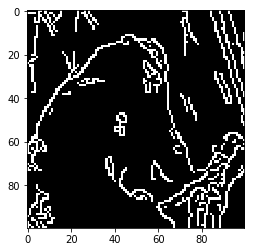

In [17]:
plt.imshow(x_train1[0])

### Custom model

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (100, 100,3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Conv2D(64, (3, 3),kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3, 3)))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(activation = 'softmax', units=4))

In [19]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics = ['accuracy']) #changed from adam to sgd

In [20]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.1, 
                       patience=4, 
                       verbose=0, 
                       mode='min')

In [21]:
x_train1, x_cv1, y_train1, y_cv1 = train_test_split(x_train1, y_train1, test_size=0.3, random_state=42)

In [22]:
hist = model.fit(x_train1, y_train1, batch_size=24, epochs=100, verbose=1, validation_data=(x_cv1, y_cv1), callbacks=[config]) # batch size 24 to 12 to 48

Train on 2800 samples, validate on 1200 samples
Epoch 1/100
2800/2800 [==============================] - 20s 7ms/step - loss: 1.4240 - acc: 0.2775 - val_loss: 1.2863 - val_acc: 0.3742
Epoch 2/100
2800/2800 [==============================] - 7s 3ms/step - loss: 1.2491 - acc: 0.3604 - val_loss: 1.1013 - val_acc: 0.4383
Epoch 3/100
2800/2800 [==============================] - 8s 3ms/step - loss: 1.1133 - acc: 0.4311 - val_loss: 1.0191 - val_acc: 0.4450
Epoch 4/100
2800/2800 [==============================] - 7s 3ms/step - loss: 1.0415 - acc: 0.4511 - val_loss: 1.0456 - val_acc: 0.4533
Epoch 5/100
2800/2800 [==============================] - 7s 3ms/step - loss: 0.9934 - acc: 0.4804 - val_loss: 1.0403 - val_acc: 0.4500
Epoch 6/100
2800/2800 [==============================] - 7s 3ms/step - loss: 0.9433 - acc: 0.5143 - val_loss: 0.9568 - val_acc: 0.4900
Epoch 7/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.9054 - acc: 0.5371 - val_loss: 1.0156 - val_acc: 0.5092
Epoch 

### Plots

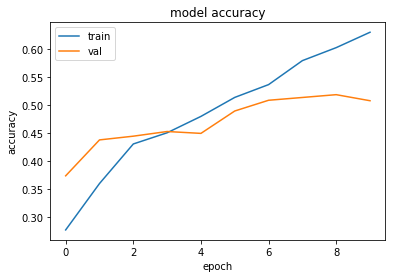

In [23]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

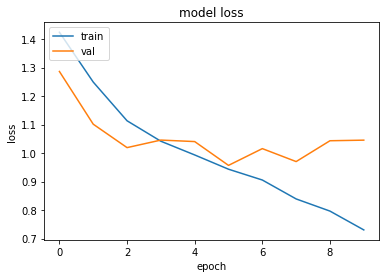

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### testing set

In [26]:
(loss, accuracy) = model.evaluate(x_test1, y_test1, batch_size=24, verbose=1)

1012/1012 [==============================] - 1s 1ms/step


In [27]:
print(loss, 'is the loss in test dataset')
print(accuracy*100, 'is the accuracy in test dataset')

1.085942924729449 is the loss in test dataset
51.38339939795935 is the accuracy in test dataset


<h4> Inference after experimenting</h4>
<p> Model seems to be predicting better on the test set with this canny filter configuration! Our experiment improved the accuracy from 48% to 51.3% on the test set</p>

## Performing more experiments to improve results....

Till now, We have been using our 4000 image dataset as such. i.e we flipped each of those images to one of the angles 0,90,180,270. But would the performance increase if we flip each of our training images to all 4 angles. So, effectively we will transform each of our 4000 training images to 4 angles. So 4000X4 = 16000 images will be our training dataset. Like wise, we can do the same to our test data inorder to check whether our model is able to generalize well!!!

In [4]:
def image_ops(img):
    
    img_array = np.array(img)
    img = cv2.resize(img_array, (100, 100))
    edges=cv2.Canny(img,100,200)
    stacked_img = np.stack((edges,)*3, axis=-1)
    return stacked_img

In [16]:
def rotater(img):
    
    "This function rotates each of our image to each of the four angles and returns all those images with their labels"
    
    angle0 = 0
    angle90 = 90
    angle180 = 180
    angle270 = 270
    
    img2 = img.rotate(angle90)
    img3 = img.rotate(angle180)
    img4 = img.rotate(angle270)
    
    return img, img2, img3, img4, angle0, angle90, angle180, angle270

In [19]:
def create_data_4d(path):
    
    """Same the create_data function we worked previously with some additions to support appending of 4 seperate images. 
    THE CODE CAN BE OPTIMIZED FURTHER. I have not done it in the interest of time"""
    
    path = path
    data_path = os.listdir(path)
    test_img_list = []
    test_labels_list = []

    img_rows = 100
    img_cols = 100

    total_length = int(len(data_path))
    first_cut = int(np.floor(total_length/4))
    second_cut = int(2*first_cut)
    third_cut = int(3*first_cut)

    
    for index in range (0, total_length):

        if 0 <= index < first_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)


        elif first_cut<= index < second_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

        elif second_cut<= index <third_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

        else:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

            
    test_img_array = np.array(test_img_list)
    test_img_array = test_img_array.astype('float32')
    test_img_array/=255
    
    test_labels_array = np.array(test_labels_list)
    test_labels = np.array(pd.get_dummies(test_labels_array))
    print("Sucessfully loaded!")
    
    test_img_array, test_labels = shuffle(test_img_array, test_labels, random_state=42)
    
    return test_img_array, test_labels

In [20]:
x_train1,y_train1 = create_data_4d(path=os.path.join(os.getcwd(), './training_set/training_set/dogs/'))

Sucessfully loaded!


In [21]:
x_test1,y_test1 = create_data_4d(path=os.path.join(os.getcwd(), './test_set/test_set/dogs/'))

Sucessfully loaded!


In [120]:
y_train_labels = (np.argmax(y_train1, axis=1))
y_test_labels = (np.argmax(y_test1, axis=1))

In [121]:
y_train_labels = pd.DataFrame({"labels":y_train_labels})
y_test_labels = pd.DataFrame({"labels":y_test_labels})

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

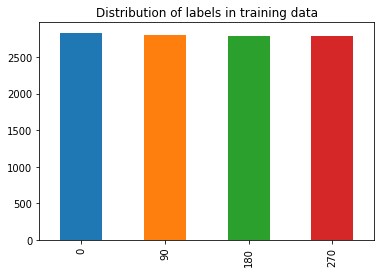

In [125]:
ax1 = y_train_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in training data")
ax1.set_xticklabels([0,90,180,270])

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

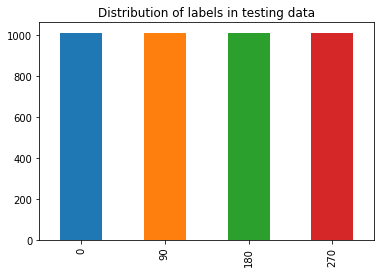

In [126]:
ax1 = y_test_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in testing data")
ax1.set_xticklabels([0,90,180,270])

As mentioned earlier, Our input has 16000 images and test will have 4048 images

In [22]:
print(x_train1.shape, ' is the shape of the training data')
print(y_train1.shape, ' is the shape of the training labels')

(16000, 100, 100, 3)  is the shape of the training data
(16000, 4)  is the shape of the training labels


In [23]:
print(x_test1.shape, ' is the shape of the training data')
print(y_test1.shape, ' is the shape of the training labels')

(4048, 100, 100, 3)  is the shape of the training data
(4048, 4)  is the shape of the training labels


### Inception Model

In [24]:
input_shape = Input(shape=(100,100,3))
inception_model = InceptionV3(include_top = True, weights = 'imagenet', input_tensor = input_shape)

In [25]:
num_classes = 4
last_layer = inception_model.get_layer('predictions').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
inception_final = Model(input_shape, out)
inception_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

config = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5,mode='auto')

inception_final.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

for layers in inception_final.layers[:-1]:
    layers.trainable = False

In [27]:
x_train1, x_cv1, y_train1, y_cv1 = train_test_split(x_train1, y_train1, test_size=0.3, random_state=42)

In [28]:
hist = inception_final.fit(x_train1, y_train1, batch_size=96, epochs=50, verbose=1, validation_data=[x_cv1, y_cv1], callbacks=[config])

Train on 11200 samples, validate on 4800 samples
Epoch 1/50
11200/11200 [==============================] - 233s 21ms/step - loss: 1.3566 - acc: 0.3288 - val_loss: 1.3880 - val_acc: 0.2433
Epoch 2/50
11200/11200 [==============================] - 204s 18ms/step - loss: 1.2923 - acc: 0.3964 - val_loss: 1.4192 - val_acc: 0.2433
Epoch 3/50
11200/11200 [==============================] - 202s 18ms/step - loss: 1.2615 - acc: 0.3994 - val_loss: 1.4432 - val_acc: 0.2433
Epoch 4/50
11200/11200 [==============================] - 202s 18ms/step - loss: 1.2020 - acc: 0.4187 - val_loss: 1.4811 - val_acc: 0.2433
Epoch 5/50
11200/11200 [==============================] - 202s 18ms/step - loss: 1.1342 - acc: 0.4393 - val_loss: 1.5229 - val_acc: 0.2433
Epoch 6/50
11200/11200 [==============================] - 202s 18ms/step - loss: 1.0985 - acc: 0.4386 - val_loss: 1.5787 - val_acc: 0.2433


### Accuracy and loss plots

Text(0.5,0,'epoch')

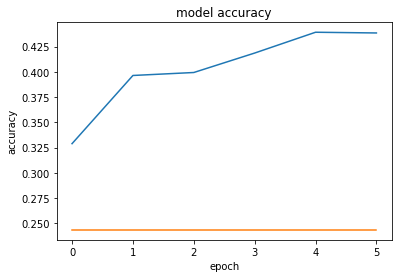

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

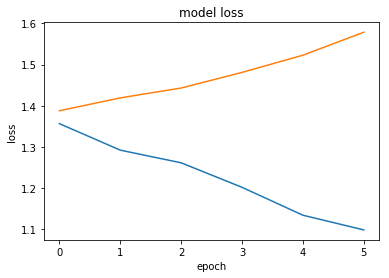

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

### Test our model

In [31]:
(loss, accuracy) = inception_final.evaluate(x_test1, y_test1, batch_size=96)

4048/4048 [==============================] - 22s 5ms/step


In [32]:
print('Loss in the test set for inception v3 is', loss)
print('Accuracy in the test set for inception v3 is', accuracy)

Loss in the test set for inception v3 is 1.5743684193833543
Accuracy in the test set for inception v3 is 0.2500000007067744


### vgg model

In [40]:
input_shape = Input(shape=(100,100,3))
vgg_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = input_shape)

In [41]:
#Here we will add couple of dense layers unlike in inception v3 where we added only one 4 neuron dense on top of 1000 neuron output

num_classes = 4
last_layer = vgg_model.get_layer('block5_pool').output
out1 = Flatten()(last_layer)
out2 = Dense(128, activation='softmax', name='out2')(out1)
out3 = Dense(num_classes, activation='softmax', name='output')(out2)
vgg_model = Model(input_shape, out3)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [43]:
vgg_model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

for layers in vgg_model.layers[:-1]:
    layers.trainable = False

In [44]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.1, 
                       patience=4, 
                       verbose=0, 
                       mode='min')

In [45]:
hist = vgg_model.fit(x_train1,y_train1, batch_size=96, epochs=50, verbose=1, validation_data=[x_cv1, y_cv1], callbacks=[config])

Train on 11200 samples, validate on 4800 samples
Epoch 1/50
11200/11200 [==============================] - 226s 20ms/step - loss: 1.3856 - acc: 0.2534 - val_loss: 1.3848 - val_acc: 0.3510
Epoch 2/50
11200/11200 [==============================] - 213s 19ms/step - loss: 1.3842 - acc: 0.3407 - val_loss: 1.3835 - val_acc: 0.2929
Epoch 3/50
11200/11200 [==============================] - 213s 19ms/step - loss: 1.3828 - acc: 0.3601 - val_loss: 1.3822 - val_acc: 0.2523
Epoch 4/50
11200/11200 [==============================] - 213s 19ms/step - loss: 1.3815 - acc: 0.2990 - val_loss: 1.3808 - val_acc: 0.3910
Epoch 5/50
11200/11200 [==============================] - 213s 19ms/step - loss: 1.3801 - acc: 0.3658 - val_loss: 1.3796 - val_acc: 0.3929


### Accuracy and loss plots

Text(0.5,0,'epoch')

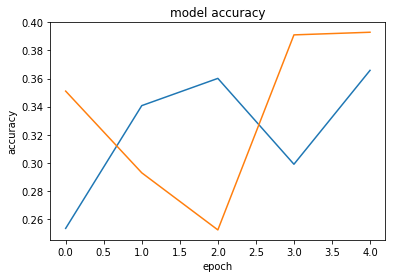

In [46]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

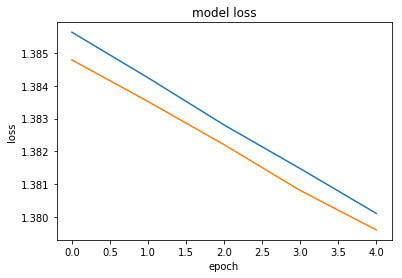

In [47]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [48]:
(loss, accuracy) = vgg_model.evaluate(x_test1, y_test1, batch_size=24)
print('The loss for the test dataset is ', loss)
print('The accuracy for the test dataset is ', accuracy)

4048/4048 [==============================] - 70s 17ms/step
The loss for the test dataset is  1.3793429353020408
The accuracy for the test dataset is  0.39896245050453855


### Custom model

In [104]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape = (100, 100,3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Conv2D(96, (3, 3),kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3, 3)))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(activation = 'softmax', units=4))

In [105]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics = ['accuracy']) #changed from adam to sgd

In [107]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.08, 
                       patience=6, 
                       verbose=0, 
                       mode='min')

In [108]:
hist = model.fit(x_train1, y_train1, batch_size=96, epochs=100, verbose=1, validation_data=(x_cv1, y_cv1), callbacks=[config]) # batch size 24 to 12 to 48

Train on 11200 samples, validate on 4800 samples
Epoch 1/100
11200/11200 [==============================] - 44s 4ms/step - loss: 1.4175 - acc: 0.2543 - val_loss: 1.3832 - val_acc: 0.3185
Epoch 2/100
11200/11200 [==============================] - 42s 4ms/step - loss: 1.2998 - acc: 0.3278 - val_loss: 1.1167 - val_acc: 0.4200
Epoch 3/100
11200/11200 [==============================] - 42s 4ms/step - loss: 1.1218 - acc: 0.4259 - val_loss: 1.0482 - val_acc: 0.4646
Epoch 4/100
11200/11200 [==============================] - 41s 4ms/step - loss: 1.0400 - acc: 0.4439 - val_loss: 0.9899 - val_acc: 0.4421
Epoch 5/100
11200/11200 [==============================] - 42s 4ms/step - loss: 0.9941 - acc: 0.4656 - val_loss: 0.9577 - val_acc: 0.4665
Epoch 6/100
11200/11200 [==============================] - 42s 4ms/step - loss: 0.9633 - acc: 0.4805 - val_loss: 0.9281 - val_acc: 0.4829
Epoch 7/100
11200/11200 [==============================] - 42s 4ms/step - loss: 0.9282 - acc: 0.5054 - val_loss: 0.9237 - v

### Plots

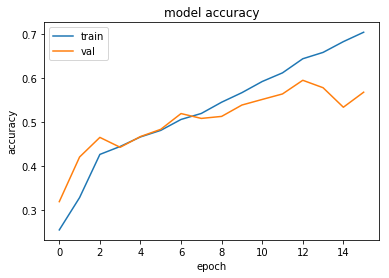

In [109]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

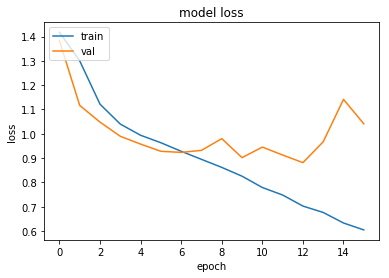

In [110]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### testing set

In [111]:
(loss, accuracy) = model.evaluate(x_test1, y_test1, batch_size=96, verbose=1)

4048/4048 [==============================] - 6s 1ms/step


In [112]:
print(loss, 'is the loss in test dataset')
print(accuracy*100, 'is the accuracy in test dataset')

1.0881873548266445 is the loss in test dataset
56.571146033026956 is the accuracy in test dataset


## PART 2

In [2]:
def image_ops(img):
    
    img_array = np.array(img)
    img = cv2.resize(img_array, (100, 100))

    return img

In [3]:
def rotater(img):
    
    "This function rotates each of our image to each of the four angles and returns all those images with their labels"
    
    angle0 = 0
    angle90 = 90
    angle180 = 180
    angle270 = 270
    
    img2 = img.rotate(angle90)
    img3 = img.rotate(angle180)
    img4 = img.rotate(angle270)
    
    return img, img2, img3, img4, angle0, angle90, angle180, angle270

In [4]:
def create_data_4d(path):
    
    """Same the create_data function we worked previously with some additions to support appending of 4 seperate images. 
    THE CODE CAN BE OPTIMIZED FURTHER. I have not done it in the interest of time"""
    
    path = path
    data_path = os.listdir(path)
    test_img_list = []
    test_labels_list = []

    img_rows = 100
    img_cols = 100

    total_length = int(len(data_path))
    first_cut = int(np.floor(total_length/4))
    second_cut = int(2*first_cut)
    third_cut = int(3*first_cut)

    
    for index in range (0, total_length):

        if 0 <= index < first_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)


        elif first_cut<= index < second_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

        elif second_cut<= index <third_cut:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

        else:

            img = Image.open(path + data_path[index])
            (img, img1, img2, img3, angle0, angle90, angle180, angle270) = rotater(img)
            stacked_img = image_ops(img)
            stacked_img1 = image_ops(img1)
            stacked_img2 = image_ops(img2)
            stacked_img3 = image_ops(img3)
            test_img_list.append(stacked_img)
            test_img_list.append(stacked_img1)
            test_img_list.append(stacked_img2)
            test_img_list.append(stacked_img3)
            test_labels_list.append(angle0)
            test_labels_list.append(angle90)
            test_labels_list.append(angle180)
            test_labels_list.append(angle270)

            
    test_img_array = np.array(test_img_list)
    test_img_array = test_img_array.astype('float32')
    test_img_array/=255
    
    test_labels_array = np.array(test_labels_list)
    test_labels = np.array(pd.get_dummies(test_labels_array))
    print("Sucessfully loaded!")
    
    test_img_array, test_labels = shuffle(test_img_array, test_labels, random_state=42)
    
    return test_img_array, test_labels

In [5]:
x_train1,y_train1 = create_data_4d(path=os.path.join(os.getcwd(), './training_set/training_set/dogs/'))

Sucessfully loaded!


In [6]:
x_test1,y_test1 = create_data_4d(path=os.path.join(os.getcwd(), './test_set/test_set/dogs/'))

Sucessfully loaded!


In [7]:
y_train_labels = (np.argmax(y_train1, axis=1))
y_test_labels = (np.argmax(y_test1, axis=1))

In [8]:
y_train_labels = pd.DataFrame({"labels":y_train_labels})
y_test_labels = pd.DataFrame({"labels":y_test_labels})

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

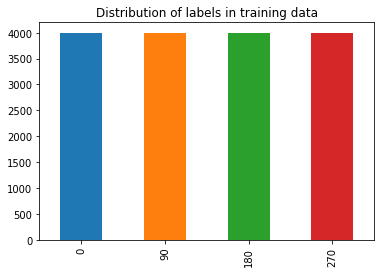

In [9]:
ax1 = y_train_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in training data")
ax1.set_xticklabels([0,90,180,270])

[Text(0,0,'0'), Text(0,0,'90'), Text(0,0,'180'), Text(0,0,'270')]

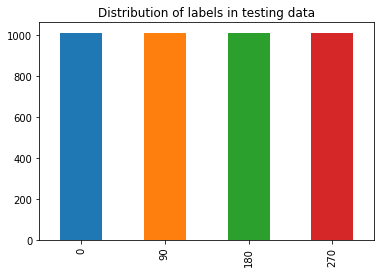

In [10]:
ax1 = y_test_labels.labels.value_counts().plot(kind="bar", title="Distribution of labels in testing data")
ax1.set_xticklabels([0,90,180,270])

As mentioned earlier, Our input has 16000 images and test will have 4048 images

In [11]:
print(x_train1.shape, ' is the shape of the training data')
print(y_train1.shape, ' is the shape of the training labels')

(16000, 100, 100, 3)  is the shape of the training data
(16000, 4)  is the shape of the training labels


In [12]:
print(x_test1.shape, ' is the shape of the training data')
print(y_test1.shape, ' is the shape of the training labels')

(4048, 100, 100, 3)  is the shape of the training data
(4048, 4)  is the shape of the training labels


### Augument

In [13]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[0.5,1.0])  

datagen.fit(x_train1)

### Custom model

In [14]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape = (100, 100,3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3))) 

model.add(Conv2D(96, (3, 3),kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3, 3)))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (3,3)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.50)) 

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(activation = 'softmax', units=4))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics = ['accuracy']) #changed from adam to sgd

In [16]:
config = EarlyStopping(monitor='val_loss', 
                       min_delta=0.08, 
                       patience=6, 
                       verbose=0, 
                       mode='min')

from keras.callbacks import ModelCheckpoint

augmented_checkpoint = ModelCheckpoint('augmented_best_model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [17]:
x_train1, x_cv1, y_train1, y_cv1 = train_test_split(x_train1, y_train1, test_size=0.3, random_state=42)

In [20]:
hist = model.fit_generator(datagen.flow(x_train1, y_train1, batch_size=96), steps_per_epoch = len(x_train1) / 32, epochs=100, verbose=1, validation_data=(x_cv1, y_cv1), callbacks=[config, augmented_checkpoint]) # batch size 24 to 12 to 48

Epoch 1/100
350/350 [==============================] - 599s 2s/step - loss: 1.2784 - acc: 0.3308 - val_loss: 0.9317 - val_acc: 0.4692
Epoch 2/100
350/350 [==============================] - 655s 2s/step - loss: 1.1721 - acc: 0.3803 - val_loss: 0.9944 - val_acc: 0.4919
Epoch 3/100
350/350 [==============================] - 673s 2s/step - loss: 1.1471 - acc: 0.3933 - val_loss: 0.9108 - val_acc: 0.5198
Epoch 4/100
350/350 [==============================] - 582s 2s/step - loss: 1.1268 - acc: 0.4144 - val_loss: 0.9119 - val_acc: 0.5225
Epoch 5/100
350/350 [==============================] - 570s 2s/step - loss: 1.1113 - acc: 0.4277 - val_loss: 0.8131 - val_acc: 0.5631
Epoch 6/100
350/350 [==============================] - 583s 2s/step - loss: 1.1040 - acc: 0.4321 - val_loss: 0.8212 - val_acc: 0.5779
Epoch 7/100
350/350 [==============================] - 613s 2s/step - loss: 1.0894 - acc: 0.4511 - val_loss: 0.8331 - val_acc: 0.5748
Epoch 8/100
350/350 [==============================] - 679s 2s

### Plots

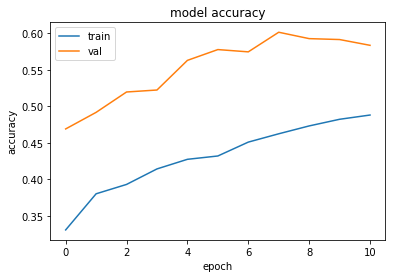

In [21]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

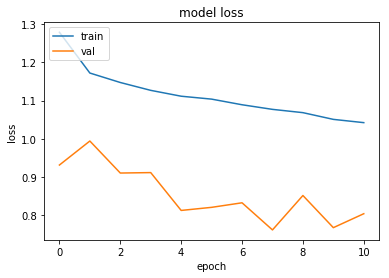

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### testing set

In [23]:
(loss, accuracy) = model.evaluate(x_test1, y_test1, batch_size=96, verbose=1)

4048/4048 [==============================] - 21s 5ms/step


In [24]:
print(loss, 'is the loss in test dataset')
print(accuracy*100, 'is the accuracy in test dataset')

0.799085240825834 is the loss in test dataset
58.76976312855958 is the accuracy in test dataset


### Results

| Canny filter thresholds | Train shape       | Test shape       | Model                              | Train accuracy | Train loss | Validation accuracy | Validation loss | Test loss | Test accuracy |
|-------------------------|-------------------|------------------|------------------------------------|----------------|------------|---------------------|-----------------|-----------|---------------|
| (400,200)               | (4000,100,100,3)  | (1012,100,100,3) | Inception V3 with Imagenet weights | 37.86          | 1.24       | 25.3                | 1.43            | 1.44      | 25            |
| (400,200)               | (4000,100,100,3)  | (1012,100,100,3) | VGG16 with Imagenet weights        | 25.71          | 1.58       | 23.3                | 1.38            | 1.38      | 25            |
| (400,200)               | (4000,100,100,3)  | (1012,100,100,3) | Custom CNN Model                   | 56.32          | 0.94       | 47.17               | 1.06            | 1.05      | 48.41         |
| (100,200)               | (16000,100,100,3) | (4048,100,100,3) | Inception V3 with Imagenet weights | 43.86          | 1.09       | 24.33               | 1.57            | 1.57      | 25            |
| (100,200)               | (16000,100,100,3) | (4048,100,100,3) | VGG16 with Imagenet weights        | 36.58          | 1.38       | 39.29               | 1.37            | 1.37      | 39.89         |
| (100,200)               | (16000,100,100,3) | (4048,100,100,3) | Custom CNN Model                   | 70.36          | 0.60       | 56.73               | 1.04            | 1.08      | 56.57         |
| No canny instead use data augumentation              | (16000,100,100,3) | (4048,100,100,3) | Custom CNN Model                   | 48.85        | 1.04       | 58.3              | 0.804           | 0.799      | 58.769        |

<h3> Final Inference </h3>
<p> Previously we were using the original dataset which consisted of 4000 images and now we have augumented every image into 4 images of different angle of tilt and now we are working with 16000 images in total. Our testing data consists of 4048 images which is produced in the same way.

The other important things worth mentioning is the use of different canny filter size thresholds with this dataset which is (100,200) whereas we were using a (400,200) threshold. The use of this new filter setting has proven to be useful in another experiment which we performed before the actual testing.